In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pydmps.dmp_discrete import DMPs_discrete
from pydmps.dmp_rhythmic import DMPs_rhythmic

try:
    import re
    with open('data.txt', 'r') as f:
        text = f.read()
        text = text.replace('[', '').replace(']', '').replace('\n', '')
        trajectory_data = np.fromstring(text, sep=' ').reshape(-1, 7)
except:
    print("Trajectory not found")
    trajectory_data = np.zeros((400, 7))

T, D = trajectory_data.shape

In [2]:
# --------------------------------------------------
# Coarse split: reach vs. stir
# --------------------------------------------------
split_idx = 70   # initial guess
reach_data_coarse = trajectory_data[:split_idx, :]
stir_data_coarse  = trajectory_data[split_idx:, :]

In [3]:
def smooth_cycle_edges(cycle_data, k=5):
    """
    Smooth first and last k samples of a cycle so that positions and
    velocities are closer across the wrap.

    cycle_data : (L, D) array  – one open cycle (start..end, NOT yet closed)
    k          : how many samples at each end to smooth (default 5)

    returns    : (L, D) array  – smoothed cycle with last == first
    """
    L, D = cycle_data.shape
    assert L > 2*k + 2, "Cycle too short for the requested smoothing window."

    # ----- 1) Circularly pad and compute moving average -----
    pad = k
    idx = np.arange(-pad, L + pad)         # [-k, ..., L-1+k]
    idx_mod = idx % L                      # wrap around
    extended = cycle_data[idx_mod]         # (L + 2k, D)

    # moving-average kernel of length 2k+1
    kernel = np.ones(2*pad + 1) / float(2*pad + 1)

    y_smooth = np.zeros_like(cycle_data)
    for d in range(D):
        # 'valid' gives length L
        conv = np.convolve(extended[:, d], kernel, mode='valid')
        y_smooth[:, d] = conv

    # ----- 2) Blend original with smoothed only at edges -----
    out = cycle_data.copy()
    for i in range(k):
        alpha = (i + 1) / float(k + 1)   # 0 -> 1 across the k points

        # beginning
        out[i, :] = (1.0 - alpha) * cycle_data[i, :] + alpha * y_smooth[i, :]

        # end (mirror)
        out[L - 1 - i, :] = (
            (1.0 - alpha) * cycle_data[L - 1 - i, :] +
            alpha * y_smooth[L - 1 - i, :]
        )

    # ----- 3) Enforce exact positional periodicity -----
    out[-1, :] = out[0, :]

    return out

In [4]:
# --------------------------------------------------
# Helper: find local minima (simple, SciPy-free)
# --------------------------------------------------
def find_local_minima(x):
    return np.array([
        i for i in range(1, len(x)-1)
        if x[i] <= x[i-1] and x[i] <= x[i+1]
    ], dtype=int)

# --------------------------------------------------
# 2.1 – Find cycle boundaries in the stirring segment
# --------------------------------------------------
'''
reach_data : what the discrete DMP should learn (reach → bowl).
cycle_data_closed : one closed, shared cycle across all 7 dimensions for the rhythmic DMPs.
'''
anchor_dim = 3  # 4th joint as anchor
anchor_stir = stir_data_coarse[:, anchor_dim]

mins = find_local_minima(anchor_stir)

if len(mins) < 3:
    raise RuntimeError("Not enough minima found; try a different anchor_dim or check the data.")

# Option: skip first minimum or two (early transitions are less stable)
skip_cycles = 0  # skip first cycle; 1 or 2 is usually enough
if skip_cycles + 1 >= len(mins):
    raise RuntimeError("skip_cycles too large for number of minima found.")

cycle_start_local = mins[skip_cycles]        # index within stir_data_coarse
cycle_end_local   = mins[skip_cycles + 1]    # index within stir_data_coarse

# Convert to indices in the full 0..399 trajectory
cycle_start = split_idx + cycle_start_local
cycle_end   = split_idx + cycle_end_local

print("Cycle indices in full trajectory:", cycle_start, cycle_end)
cycle_len = cycle_end - cycle_start + 1
print("Cycle length (samples):", cycle_len)

# --------------------------------------------------
# 2.2 – Extract refined reach + one full cycle
# --------------------------------------------------
reach_data = trajectory_data[:cycle_start, :]              # [0 .. cycle_start-1]
cycle_data = trajectory_data[cycle_start:cycle_end+1, :]   # [cycle_start .. cycle_end]

# Smooth edges of the cycle
cycle_data_closed = smooth_cycle_edges(cycle_data, k=5)    # or k=7/9 depending on how sharp it is

reach_T = reach_data.shape[0]
print("Refined reach length:", reach_T)

Cycle indices in full trajectory: 123 184
Cycle length (samples): 62
Refined reach length: 123


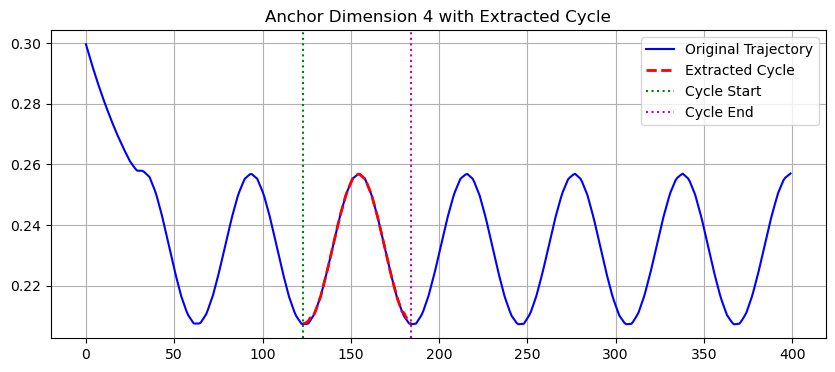

In [5]:
# Draw cycle on the original trajectory
plt.figure(figsize=(10, 4))
plt.plot(trajectory_data[:, anchor_dim], 'b', label='Original Trajectory')
plt.plot(range(cycle_start, cycle_end + 1), cycle_data_closed[:, anchor_dim], 'r--', linewidth=2, label='Extracted Cycle')
plt.axvline(x=cycle_start, color='g', linestyle=':', label='Cycle Start')
plt.axvline(x=cycle_end, color='m', linestyle=':', label='Cycle End')
plt.title(f'Anchor Dimension {anchor_dim + 1} with Extracted Cycle')
plt.legend()
plt.grid(True)
plt.show()

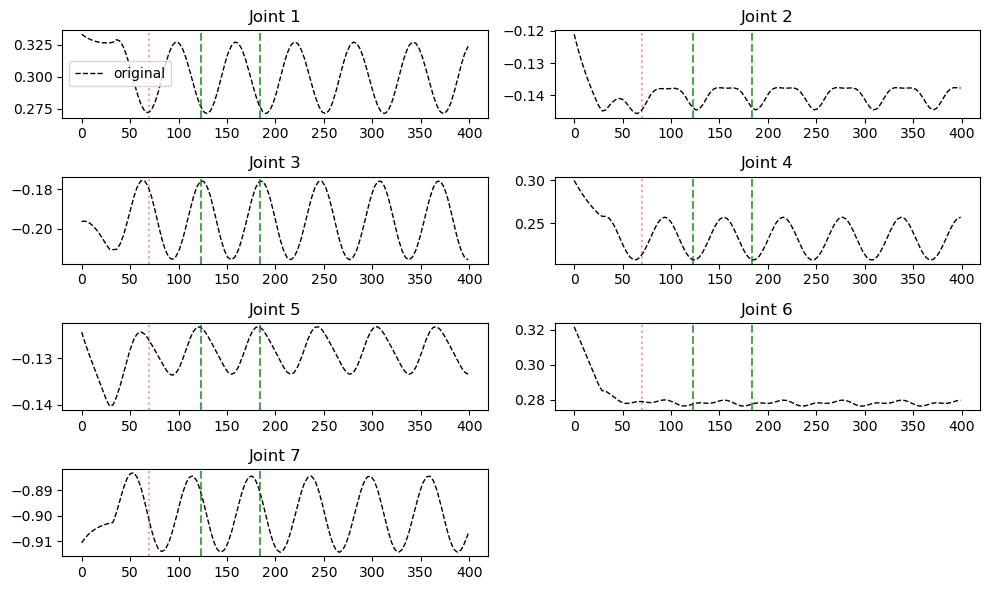

In [6]:
plt.figure(figsize=(10, 6))
for j in range(D):
    plt.subplot(4, 2, j+1)
    plt.plot(trajectory_data[:, j], 'k--', lw=1, label='original')
    plt.axvline(split_idx, color='r', ls=':', alpha=0.4)
    plt.axvline(cycle_start, color='g', ls='--', alpha=0.7)
    plt.axvline(cycle_end,   color='g', ls='--', alpha=0.7)
    if j == 0:
        plt.legend()
    plt.title(f'Joint {j+1}')
plt.tight_layout()
plt.show()

In [7]:
# --------------------------------------------------
# 3.1 – Train DMPs
# --------------------------------------------------
n_dims = D
n_bfs_discrete = 100
n_bfs_rhythmic = 100

dmp_reach_list = []
dmp_cycle_list = []

for i in range(n_dims):
    # ---------- DISCRETE (reach) ----------
    y_reach_dim = reach_data[:, i].reshape(1, -1)  # shape: (1, reach_T)
    dt_reach = 1.0 / reach_T

    d_dmp = DMPs_discrete(n_dmps=1, n_bfs=n_bfs_discrete, dt=dt_reach)
    d_dmp.imitate_path(y_des=y_reach_dim)
    dmp_reach_list.append(d_dmp)

    # ---------- RHYTHMIC (1 closed cycle) ----------
    y_cycle_dim = cycle_data_closed[:, i].reshape(1, -1)  # shape: (1, cycle_len)
    dt_cycle      = 0.01
    run_time_cycle = dt_cycle * cycle_len   # -> steps_per_cycle = cycle_len

    r_dmp = DMPs_rhythmic(
        n_dmps=1,
        n_bfs=n_bfs_rhythmic,
        dt=dt_cycle
    )
    r_dmp.imitate_path(y_des=y_cycle_dim)

    dmp_cycle_list.append(r_dmp)



# --------------------------------------------------
# 3.2 – Regenerate: reach + repeated stirring cycles
# --------------------------------------------------
stir_duration = T - reach_T
n_cycles_needed = int(np.ceil(stir_duration / cycle_len))

generated_reach_paths = []
generated_stir_paths  = []

for i in range(n_dims):
    # ------- Reach rollout -------
    d_dmp = dmp_reach_list[i]
    y_reach, _, _ = d_dmp.rollout(timesteps=reach_T)  # (reach_T, 1)
    y_reach = y_reach.reshape(-1)                     # flatten
    generated_reach_paths.append(y_reach)

    # ------- Single-cycle rollout -------
    r_dmp = dmp_cycle_list[i]
    # Start at the same value as the first cycle sample from the original
    r_dmp.y0 = np.array([cycle_data_closed[0, i]])
    steps_per_cycle = int(r_dmp.cs.run_time / r_dmp.dt)
    r_dmp.reset_state()
    y_cycle, _, _ = r_dmp.rollout(timesteps=steps_per_cycle)
    y_cycle = y_cycle.reshape(-1)
    # Downsample to original cycle length if needed
    if steps_per_cycle != cycle_len:
        indices = np.linspace(0, steps_per_cycle - 1, cycle_len).astype(int)
        y_cycle = y_cycle[indices]

    # Tile the learned cycle to cover the remaining time
    y_stir_full = np.tile(y_cycle, n_cycles_needed)[:stir_duration]
    generated_stir_paths.append(y_stir_full)

# Stack dimensions back together
full_reach = np.column_stack(generated_reach_paths)            # (reach_T, 7)
full_stir  = np.column_stack(generated_stir_paths)             # (stir_duration, 7)
full_trajectory = np.vstack((full_reach, full_stir))           # (400, 7)
assert full_trajectory.shape == trajectory_data.shape


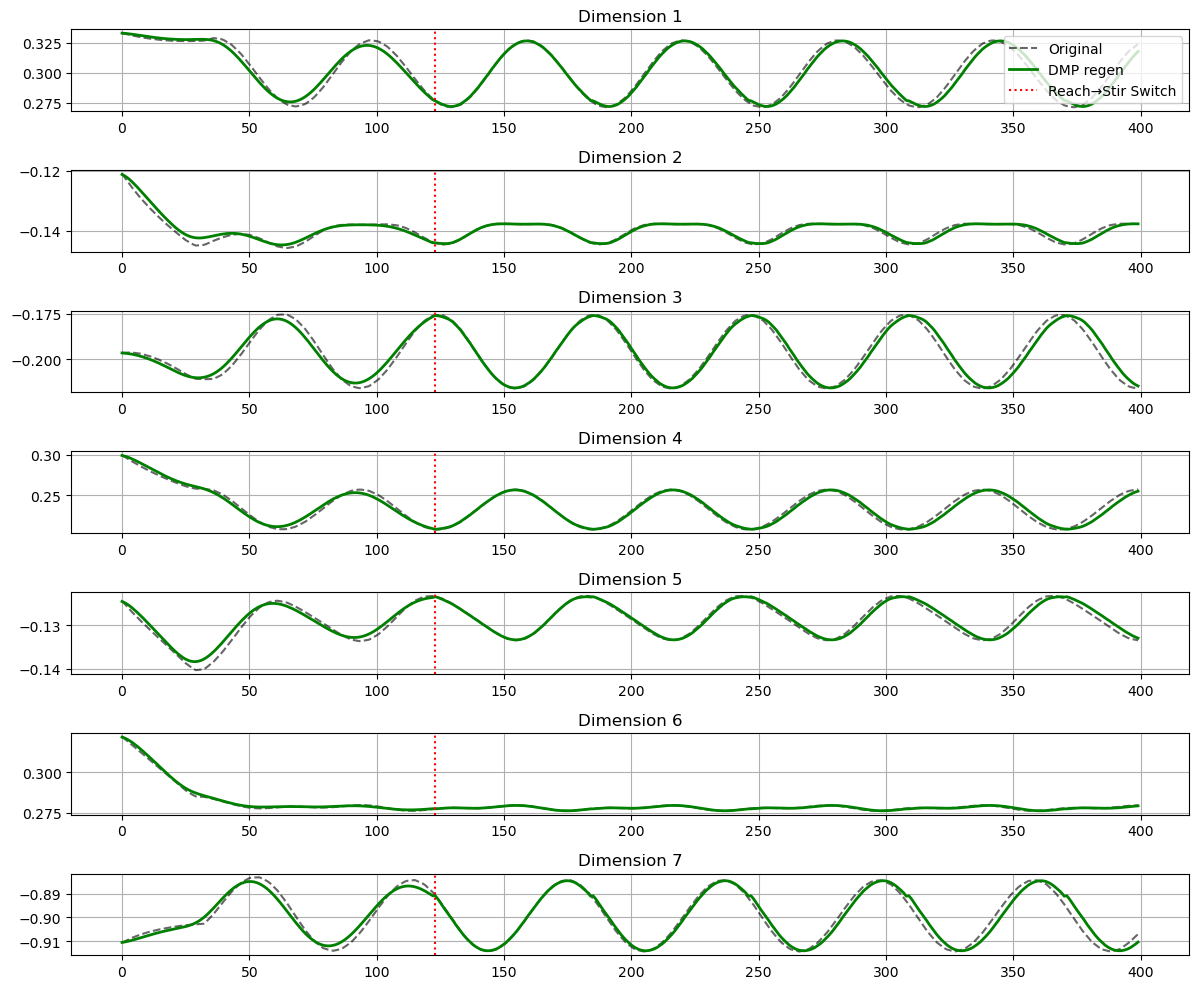

In [8]:
plt.figure(figsize=(12, 10))
for dim in range(7):
    plt.subplot(7, 1, dim+1)
    plt.plot(trajectory_data[:, dim], 'k--', alpha=0.6, label='Original')
    plt.plot(full_trajectory[:, dim], 'g', linewidth=2, label='DMP regen')
    plt.axvline(x=reach_T, color='r', linestyle=':', label='Reach→Stir Switch')
    plt.title(f'Dimension {dim+1}')
    plt.grid(True)
    if dim == 0:
        plt.legend(loc='upper right')
plt.tight_layout()
plt.show()